# Build a reference for AMP phase II RA CITE-seq, and map AMP phase I RA scRNA-seq to this reference
### Fan Zhang
### 2021-05-14

In [42]:
require(gdata)
library(readxl)
library(dplyr)
library(patchwork)
library(presto)
library(uwot)
library(harmony)
library(magrittr)
library(gridExtra)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)
library(MASS)
library(matrixStats)
library(viridis)
library(grid)
library(singlecellmethods)
library(umap)
library(tidyverse)
library(ggpubr)
library(rstatix)
library(Seurat)
library(CCA)
library(tidyverse)
library(ggthemes)
library(symphony)
library(ggrastr)


meta_colors <- list(
    
    "cell_type" = c(
        "B cell/plasma cell" = "#FDBF6F",
        "B cell" = "#FDBF6F",
        "DC" = "#CAB2D6",
        "Fibroblast" = "#08519C",
        "Stromal cell" = "#08519C",
        "Endothelial cell" = "#A6CEE3",
        "Macrophage" = "#6A3D9A",
        "Monocyte" = "#6A3D9A",
        "Myeloid cell" = "#6A3D9A",
        "T cell" = "#B2DF8A",
        "NK" = "#33A02C"
    ),

    "class" = c(
        "M" = "#9E0142",
        "T + M" = "#F46D43",
        "T + B" = "#FEE08B",
        "T + F" = "#E6F598",
        "F" = "#ABDDA4",
        "E + F + M" = "#66C2A5",
        "OA" = "grey"
    )
)

In [3]:
#' Basic function to plot cells, colored and faceted by metadata variables
#' 
#' @param metadata metadata, with UMAP labels in UMAP1 and UMAP2 slots
#' @param title Plot title
#' @param color.by metadata column name for phenotype labels
#' @param facet.by metadata column name for faceting
#' @param color.mapping custom color mapping
#' @param show.legend Show cell type legend

plotBasic = function(umap_labels,                # metadata, with UMAP labels in UMAP1 and UMAP2 slots
                        title = 'Query',         # Plot title
                        color.by = 'cell_type',  # metadata column name for coloring
                        facet.by = NULL,         # (optional) metadata column name for faceting
                        color.mapping = NULL,    # custom color mapping
                        legend.position = 'right') {  # Show cell type legend
    
    p = umap_labels %>%
            dplyr::sample_frac(1L) %>% # permute rows randomly
            ggplot(aes(x = UMAP1, y = UMAP2)) + 
            geom_point_rast(aes(col = get(color.by)), size = 0.3, stroke = 0.2, shape = 16)
        if (!is.null(color.mapping)) { p = p + scale_color_manual(values = color.mapping) }
    
    # Default formatting
    p = p + theme_bw() +
            labs(title = title, color = color.by) + 
            theme(plot.title = element_text(hjust = 0.5)) +
            theme(legend.position=legend.position) +
            theme(legend.text = element_text(size=8), legend.title=element_text(size=12)) + 
            guides(colour = guide_legend(override.aes = list(size = 4))) + guides(alpha = FALSE)

    if(!is.null(facet.by)) {
        p = p + facet_wrap(~get(facet.by)) +
                theme(strip.text.x = element_text(size = 12)) }    
    return(p)
}

# Load QCed cells from mRNA and protein matrices

In [26]:
mRNA_exprs <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/mRNA_exprs_2020-01-24.rds")
meta_all <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/fine_cluster_all_celltypes_82samples_2021-04-23.rds")
mRNA_exprs <- mRNA_exprs[, meta_all$cell]
dim(mRNA_exprs)

exprs_norm <- normalizeData(mRNA_exprs, method = "log")
dim(exprs_norm)
adt_exprs_norm <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_filter_2020-02-18.rds") # adt_exprs_norm are CLR normalized and QCed
adt_exprs_norm <- adt_exprs_norm[, meta_all$cell]
dim(adt_exprs_norm)

[1]  33538 328201

[1]  33538 328201

[1]     58 328201

In [27]:
meta_all <- meta_all[, c("cell", "sample", "cluster_number", "cluster_name", "cell_type")]

In [28]:
# Feature selection using vst on raw counts
meta_all$sample <- as.character(meta_all$sample)

# Select variable genes per sample and then take the union
var_genes <- vargenes_vst(mRNA_exprs, topn = 1000, groups = meta_all$sample)
length(var_genes)

[1] 5823

In [29]:
# Check if VST exclude cell cycle and MT and ribosome genes
mt_ri <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(exprs_norm), value = TRUE)
cycle_prolif <- c(Seurat::cc.genes$s.genes, Seurat::cc.genes$g2m.genes)
genes_exclude <- union(mt_ri, cycle_prolif)
var_genes <- var_genes[-which(var_genes %in% genes_exclude)]
length(var_genes)
rm(mRNA_exprs) # Don't need raw count data anymore

[1] 5751

In [30]:
# Normalized data with highly variable genes
ref_exp = exprs_norm[var_genes, ]
dim(ref_exp)
rm(exprs_norm)

[1]   5751 328201

In [31]:
# Calculate and save the mean and standard deviations for each gene
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp, vargenes_means_sds$mean)
head(vargenes_means_sds)
dim(vargenes_means_sds)
saveRDS(vargenes_means_sds, "all_cells_vargenes_means_sds_2021-05-20.rds")

symbol,mean,stddev
IGHA1,0.3966540,0.7501617
IGLC2,0.8484138,1.1498599
IGHG2,0.0721903,0.3591387
IGLC3,0.4520035,0.8971236
JCHAIN,0.2230015,0.6807754
SPP1,0.3448693,0.9752211


[1] 5751    3

In [33]:
# Use the most cell type-specific proteins based on KL divergence for each protein
adt_exprs_norm <- adt_exprs_norm[c("CD11b_prot", "CD64_prot", "CD34_prot", "Podoplanin_prot", "CD3_prot", "CD11c_prot", "CD31_prot", "CD206/MMR_prot",
                                   "FR-beta_prot", "CD278/ICOS_prot", "CD90/THY1_prot", "HLA-DR_prot", "CD45RO_prot", "EGFR_prot",
                                   "CD141/Thrombomodulin_prot", "CD27(LG.3A10)_prot", "CD112/Nectin-2_prot", "CD4_prot", "CD45RA_prot",
                                   "CD86_prot", "CD146_prot", "CD45(2D1)_prot", "CD14_prot", "CD127/IL-7R-alpha_prot", "CD19_prot", "CD279/PD-1_prot",
                                   "CD144/VE-Cadherin_prot", "CD107a/LAMP1_prot", "CD69_prot", "CD44_prot", "CD155/PVR_prot", "CD8a_prot", "CD20_prot",
                                   "CD21_prot", "CD68_prot", "CD163_prot", "CD192/CCR2_prot", "CD1c_prot", "CD56/NCAM_prot"),]
dim(adt_exprs_norm)

# adt_exprs_norm <- adt_exprs_norm[c("CD34_prot", "Podoplanin_prot", "CD3_prot", "CD11c_prot",
#                                    "FR-beta_prot", "CD278/ICOS_prot", "CD90/THY1_prot", "CD45RO_prot","CD27(LG.3A10)_prot", "CD4_prot", "CD45RA_prot",
#                                    "CD86_prot", "CD146_prot", "CD45(2D1)_prot", "CD14_prot", "CD127/IL-7R-alpha_prot", "CD19_prot", "CD8a_prot", "CD20_prot",
#                                    "CD21_prot", "CD68_prot", "CD163_prot", "CD192/CCR2_prot", "CD1c_prot", "CD56/NCAM_prot"),]
# dim(adt_exprs_norm)

[1]     39 328201

In [34]:
mRNA_scale <- singlecellmethods::scaleData(ref_exp) 
# Exactly the same results with singlecellmethods::scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)
protein_scale <- singlecellmethods::scaleData(adt_exprs_norm)

rm(ref_exp)
rm(adt_exprs_norm)
dim(mRNA_scale)
dim(protein_scale)

[1]   5751 328201

[1]     39 328201

In [35]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3191131,170.5,6467374,345.4,6467374,345.4
Vcells,1978966319,15098.4,4128779532,31500.1,9545045347,72823.0


In [ ]:
# This step can be PCA or CCA
# Run CCA
set.seed(0)
system.time({
    res_cca = cc(t(mRNA_scale), t(protein_scale))
    })

# Save the results
saveRDS(res_cca, "res_cca_all_328201cells_VST5751genes_39proteins_2021-05-20.rds")

rm(mRNA_scale)
rm(protein_scale)

In [43]:
## Extracting loadings
loadings <- res_cca$xcoef[,1:20]
cca_res <- res_cca$scores$xscores[,1:20]
dim(loadings)
dim(cca_res)

[1] 5751   20

[1] 328201     20

In [ ]:
## Build reference
set.seed(0)
# We have tested parameter theta (0,1,2) and select theta = 1 
system.time({
    ref_harmObj <- HarmonyMatrix(cca_res, meta_all, c("sample"), 
                                 theta = c(1), plot_convergence = TRUE, 
                                 epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
                                 max.iter.harmony = 10, max.iter.cluster = 30, 
                                 do_pca = F, verbose = T, return_object = TRUE
                                 )
})
rm(cca_res)

In [17]:
# vargenes_means_sds <- readRDS("all_cells_vargenes_means_sds_2021-05-13.rds")

# Build reference

In [ ]:
# To run the next function buildReferenceFromHarmonyObj(), you need to input the saved gene loadings (loadings) and vargenes_means_sds.
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           meta_all,           # reference cell metadata
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs matrix
                           verbose = TRUE,         # verbose output
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = './all_cells_uwot_model_2021-05-20')

In [ ]:
# Save all cell reference
saveRDS(reference, './all_cells_reference_2021-05-20.rds') 

# meta_data: metadata
# vargenes: variable genes, means, and standard deviations used for scaling
# loadings: gene loadings for projection into pre-Harmony PC space
# R: Soft cluster assignments
# Z_orig: Pre-Harmony PC embedding
# Z_corr: Harmonized PC embedding
# centroids: locations of final Harmony soft cluster centroids
# cache: pre-calculated reference-dependent portions of the mixture model
# umap: UMAP coordinates
# save_uwot_path: path to saved uwot model (for query UMAP projection into reference UMAP coordinates)
                                          

In [39]:
class(reference)

[1] "list"

## Visualize results 

In [4]:
# reference <- readRDS("all_cells_reference_2021-05-20.rds")

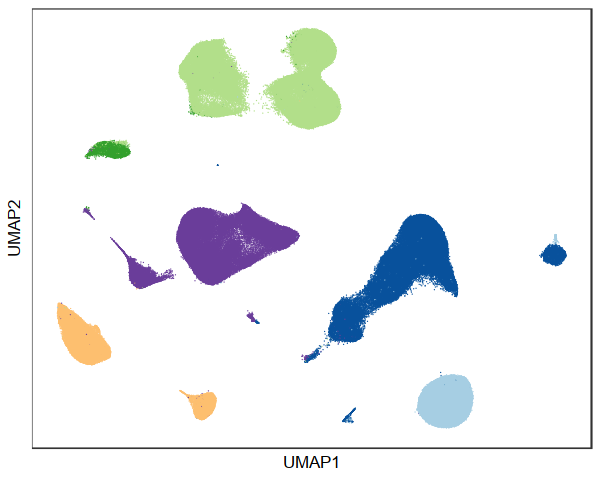

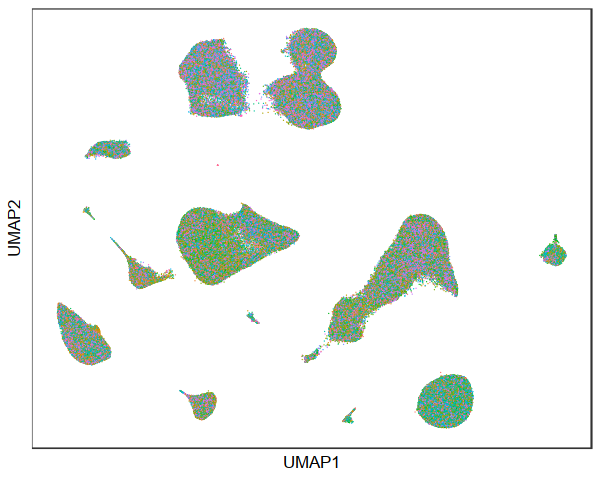

In [62]:
# res_cca_all_328201cells_VST5751genes_39proteins_2021-05-20.rds
umap_labels = cbind(reference$meta_data, reference$umap$embedding)

# fig.size(3, 5)
options(repr.plot.height = 4, repr.plot.width = 5)
ggplot() +
  geom_point(
    data = umap_labels[sample(nrow(umap_labels)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "cell_type"),
    size = 0.1, stroke = 0.0001, shape = 21
  ) +
#   facet_wrap( ~ new_cluster_name) +
  scale_fill_manual(values = meta_colors$cell_type, name = "") + 
  theme_bw(base_size = 10) +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10)
  ) 
ggsave(file = paste("all_celltype_umap", ".png", sep = ""), width = 5, height = 4, dpi = 300)

# fig.size(3, 5)
options(repr.plot.height = 4, repr.plot.width = 5)
ggplot() +
  geom_point(
    data = umap_labels[sample(nrow(umap_labels)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "sample"),
    size = 0.1, stroke = 0.0001, shape = 21
  ) +
#   facet_wrap( ~ new_cluster_name) +
#   scale_fill_manual(values = meta_colors$cell_type, name = "") + 
  theme_bw(base_size = 10) +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10)
  ) 
ggsave(file = paste("all_samples_umap", ".png", sep = ""), width = 5, height = 4, dpi = 300)

# Visualize cell type lineage protein markers

In [57]:
# adt_exprs <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_2020-01-24.rds")
# adt_exprs <- adt_exprs[, meta_all$cell]
# adt_exprs_norm <- adt_exprs %>% singlecellmethods::normalizeData(method = "cellCLR")

adt_exprs_norm <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_filter_2020-02-18.rds") # adt_exprs_norm are CLR normalized and QCed
adt_exprs_norm <- adt_exprs_norm[, umap_labels$cell]
dim(adt_exprs_norm)

[1]     58 328201

In [58]:
# rownames(adt_exprs_norm) <- substr(rownames(adt_exprs_norm), 1, nchar(rownames(adt_exprs_norm) )-5)
plot_protein <- c( "CD4_prot", "CD8a_prot", "CD127/IL-7R-alpha_prot", "CD56/NCAM_prot", 
                   "CD14_prot", "CD163_prot", "CD192/CCR2_prot", "CD1c_prot", 
                   "Podoplanin_prot", "CD90/THY1_prot", "CD34_prot", "CD31_prot", 
                   "CD146_prot", "CD19_prot", "CD20_prot"
                 )

rownames(adt_exprs_norm) <- substr(rownames(adt_exprs_norm), 1, nchar(rownames(adt_exprs_norm) )-5)
plot_protein <- substr(plot_protein, 1, nchar(plot_protein)-5)

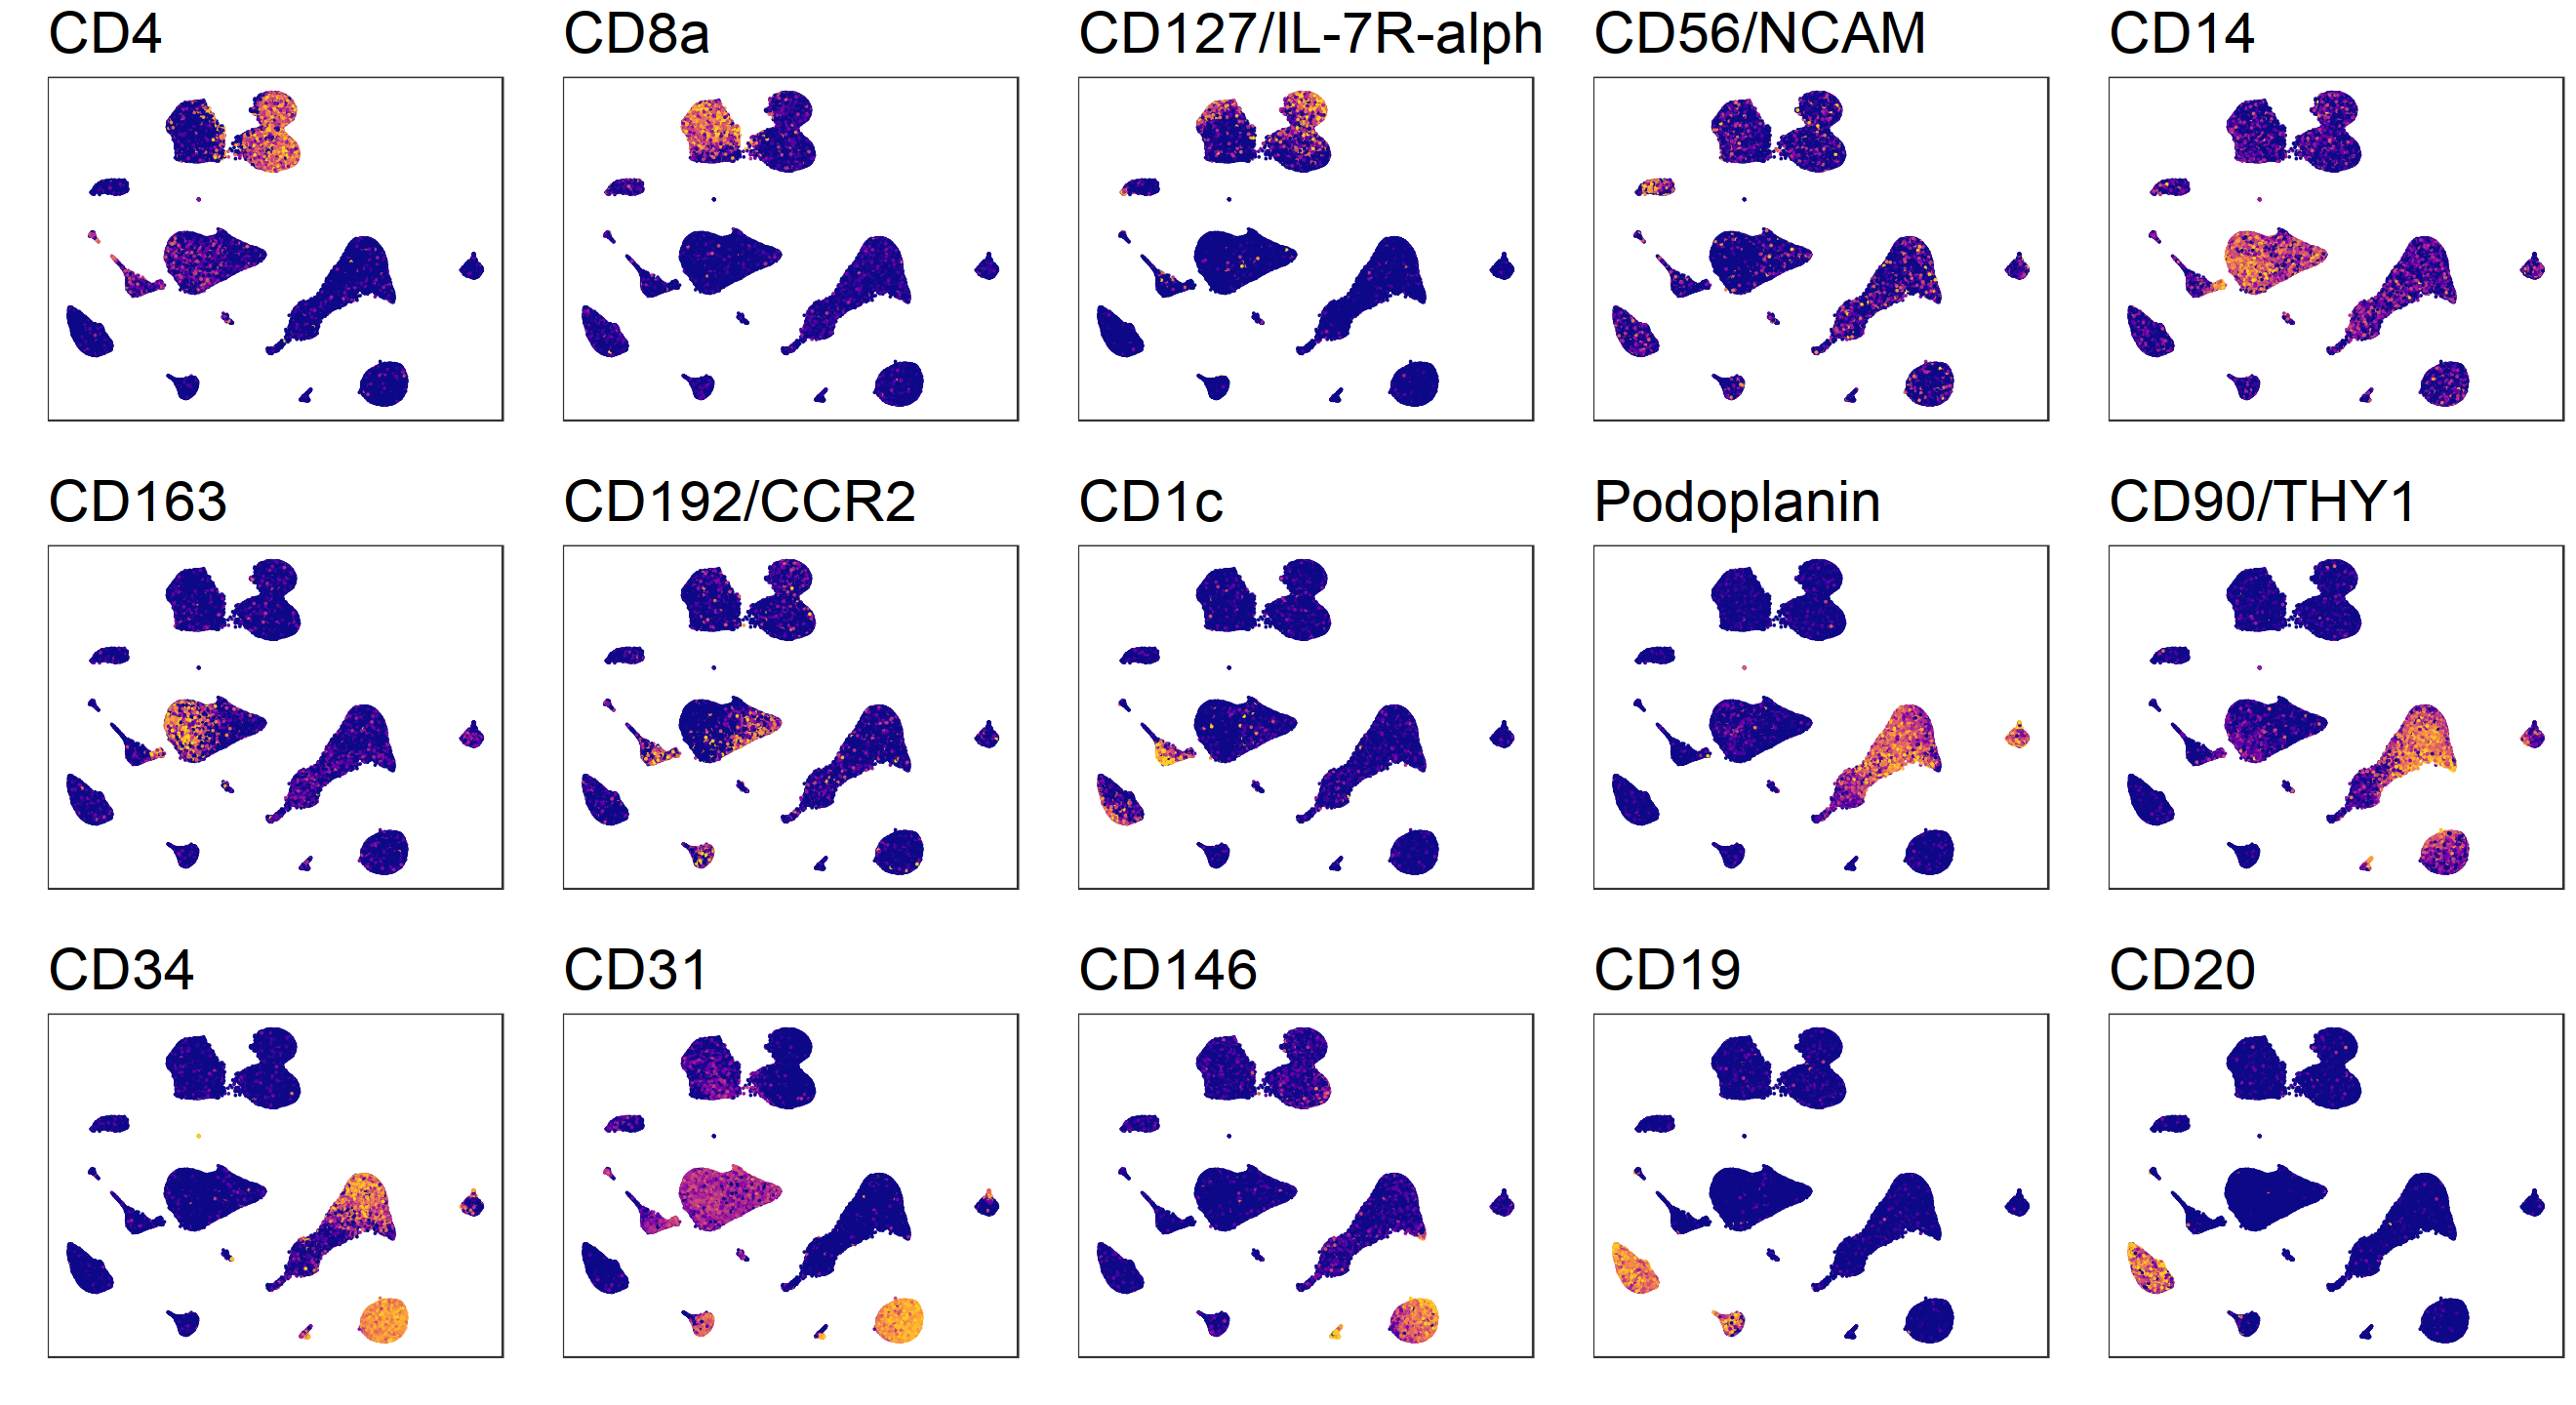

In [59]:
myplots <- list()
for (i in 1:length(plot_protein)) {
    protein <- plot_protein[i]
    
    max.cutoff = quantile(adt_exprs_norm[protein,], .99)
    min.cutoff = quantile(adt_exprs_norm[protein,], .01)

    tmp <- sapply(X = adt_exprs_norm[protein,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
  
    umap_labels$protein <- as.numeric(tmp)
    

    
   ind <- paste("p", i, sep = "")
   ind <- ggplot(
                 data = umap_labels[sample(nrow(umap_labels)),],
                 aes(x = UMAP1, y = UMAP2)) + 
      geom_point(mapping = aes(color = protein), size = 0.000001) + 
      scale_color_viridis(option = "plasma", end = .9) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=35), # face="bold.italic"
        legend.position = "none") +
      labs(title = protein)
   myplots[[i]] <- ind
    
    
}

options(repr.plot.height = 12, repr.plot.width = 22)
p <- do.call("grid.arrange", c(myplots, ncol = 5))
ggsave(file = paste("protein_umap", ".png", sep = ""), p, width = 22, height = 9, dpi = 300)

# Protein expression of cell type lineage markers help idenitfy key subpopulations
# Now let's project the fine grained clusters defined by cell type-specific analysis onto coarse anlaysis/global embeddings:

Warning message:
“ggrepel: 31 unlabeled data points (too many overlaps). Consider increasing max.overlaps”

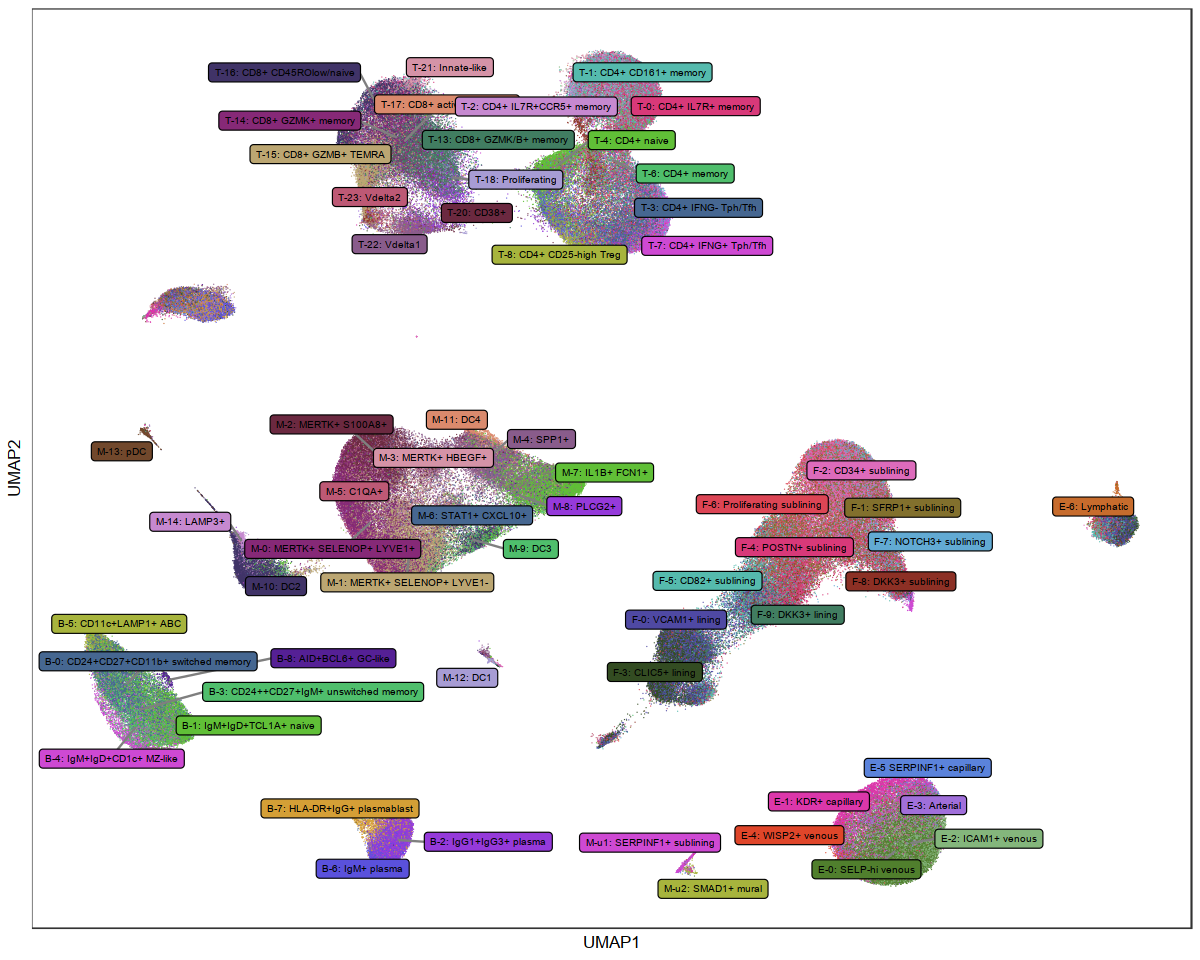

In [46]:
# Fine grained subpopulations are generally maintained in the global transcriptomic space.
# To more accurately define subpopulations, we recommend our cell type-specific references.

colors37 = c("#466791","#60bf37","#953ada","#4fbe6c","#ce49d3","#a7b43d","#5a51dc","#d49f36","#552095","#507f2d","#db37aa","#84b67c","#a06fda","#df462a","#5b83db","#c76c2d","#4f49a3","#82702d","#dd6bbb","#334c22","#d83979","#55baad","#dc4555","#62aad3","#8c3025","#417d61","#862977","#bba672","#403367","#da8a6d","#a79cd4","#71482c","#c689d0","#6b2940","#d593a7","#895c8b","#bd5975")
cluster_center <- umap_labels %>%
                  group_by(cluster_name) %>%
                  summarise_at(vars(UMAP1, UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$cluster_name <- as.character(cluster_center$cluster_name)

options(repr.plot.height = 8, repr.plot.width = 10)
ggplot(umap_labels[sample(nrow(umap_labels)),],
       aes(x = UMAP1, y = UMAP2, fill= cluster_name)
      ) +
  geom_point(size = 0.1, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = cluster_name, fill = cluster_name),
#     fontface = 'bold', 
    size = 2, 
    box.padding = unit(0.3, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = c(colors37, colors37, colors37), name = "") +
  theme_bw(base_size = 10) +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)

In [60]:
## Observations:
# - Cells are clustered into major cell types based on transcriptomic and proteomic differences;
# - Protein surface markers are helpful - more clearly seperate NK cells from CD8 T cells; seperate DCs from macrophages, etc
# - Cell type-specific analysis are done on each cell type with fine-grained clustering. Cell type-speicfic references are provided as well.

# Map query
## Map AMP phase I RA cells (query) generated from CEL-Seq2 to the built reference

In [16]:
# In order to map a new query dataset onto the reference, you will need a reference object saved from the steps above, as well as query cell expression and metadata.
# The query dataset is assumed to have been normalized in the same manner as the reference cells (here, default is log(CP10k+1) normalization).

In [47]:
query_exp <- readRDS("/data/srlab/fzhang/amp/data/amp_ra_phase1/celseq_synovium_log2_5265cells_paper.rds")
query_metadata <- readRDS("/data/srlab/fzhang/amp/data/amp_ra_phase1/celseq_synovium_meta_5265cells_paper.rds")
colnames(query_metadata)[2] <- "cell"
query_metadata <- query_metadata[, c("cell", "sample", "cell_type", "disease", "plate", "cluster", "Mahalanobis_20")]
dim(query_exp)
dim(query_metadata)
query_metadata[1:4,]

[1] 32391  5265

[1] 5265    7

,cell,sample,cell_type,disease,plate,cluster,Mahalanobis_20
4264,S006_L1Q1_A03,301-0159,T cell,OA,S006,SC-T1,OA
4265,S006_L1Q1_A05,301-0159,T cell,OA,S006,SC-T4,OA
4266,S006_L1Q1_A07,301-0159,T cell,OA,S006,SC-T1,OA
4267,S006_L1Q1_A09,301-0159,T cell,OA,S006,SC-T1,OA


In [48]:
# Map query
query = mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 reference,             # Symphony reference object
                 vars = c('sample'),    # also integrate over query batches
                 do_normalize = FALSE,  # perform log(CP10k) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

Scaling and synchronizing query gene expression
Found 4676 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


In [49]:
# Predict query cell types using k-NN
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)

In [50]:
head(query$meta_data)

,cell,sample,cell_type,disease,plate,cluster,Mahalanobis_20,cell_type_pred_knn
4264,S006_L1Q1_A03,301-0159,T cell,OA,S006,SC-T1,OA,T cell
4265,S006_L1Q1_A05,301-0159,T cell,OA,S006,SC-T4,OA,T cell
4266,S006_L1Q1_A07,301-0159,T cell,OA,S006,SC-T1,OA,T cell
4267,S006_L1Q1_A09,301-0159,T cell,OA,S006,SC-T1,OA,T cell
4268,S006_L1Q1_A11,301-0159,T cell,OA,S006,SC-T4,OA,T cell
4269,S006_L1Q1_A15,301-0159,T cell,OA,S006,SC-T4,OA,T cell


In [51]:
# Visualize of mapping
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query$meta_data[, c("cell", "sample", "cell_type", "cell_type_pred_knn", "ref_query")], reference$meta_data[, c("cell", "sample", "cell_type", "cell_type_pred_knn", "ref_query")])
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

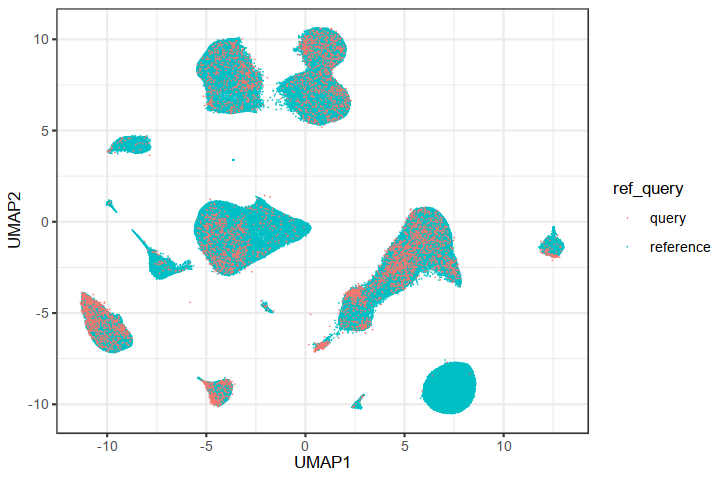

In [53]:
# Plot UMAP visualization of all cells
# plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'ref_query')

options(repr.plot.height = 4, repr.plot.width = 6)
ggplot() +
  geom_point(
    data = umap_combined_labels[rev(order(umap_combined_labels$ref_query)),],
    mapping = aes_string(x = "UMAP1", y = "UMAP2", fill = "ref_query"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
#   facet_wrap( ~ new_cluster_name) +
#   scale_fill_manual(values = meta_colors$cell_type, name = "") + 
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
#     panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10)
  ) 

## Reference: AMP phase II; Query: AMP phase I

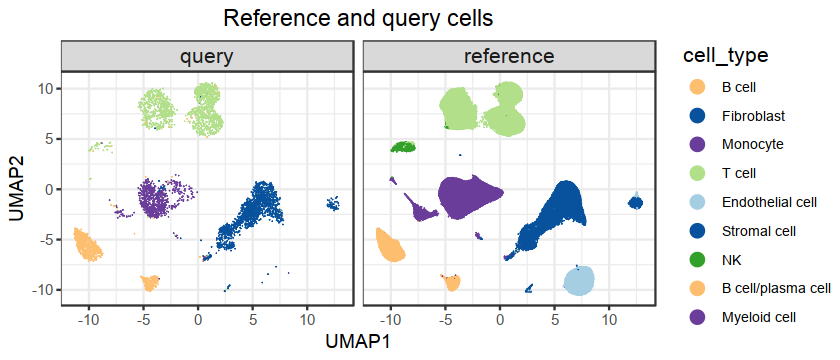

In [55]:
options(repr.plot.height = 3, repr.plot.width = 7)
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cell_type', facet.by = 'ref_query', color.mapping = meta_colors$cell_type)

In [56]:
## Summary:
# - We are able to map the query cells into the right cell types in the reference panel.
# - No endothelial cells in the query, we the query cells are not mapped to the endothelial cells in the reference.
# - A small number of CD8 T cells in the query are mapped to the NK cells in the reference, this might be acceptable since these CD8 T cells are cytotoxic so share many similar genes with NK cells.
# - To more accurately map cells onto subpopulations, we recommend mapping query cells onto cell type-specific references.

In [95]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/fz049/miniconda3/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrastr_0.2.1           symphony_1.0            ggthemes_4.2.0         
 [4] CCA_1.2                 fields_11.6             spam_2.5-1             
 [7] dotCall64_1.0-0         fda_5.1.5.1             Seurat_3.9.9.9027      
[10] rstatix_0.6.0           